### visualise additional analyses

In [1]:
import numpy as np
from nilearn import plotting
from IPython.display import Image

overlay high/low pain from jump freq model mean posterior

In [2]:
bg = '../../../TSL_anat/mean_anat.nii.gz'

In [3]:
# pmod posterior mean low pain
img_lo = '../../../TSL_output/2ndLevel_io_jf_pp_pe_hl_FDR0001/2ndLevel/con_0001/spmT_0001_thr.nii'
img_hi = '../../../TSL_output/2ndLevel_io_jf_pp_pe_hl_FDR0001/2ndLevel/con_0002/spmT_0001_thr.nii'
z_map = img_lo

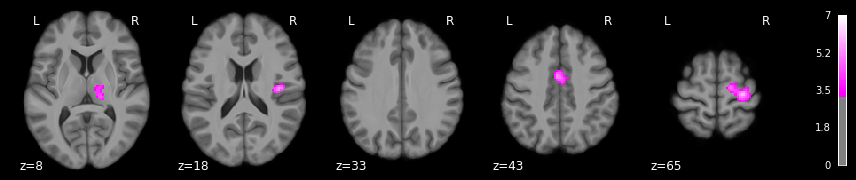

In [4]:
from nilearn.glm import threshold_stats_img
clean_map, threshold = threshold_stats_img(
    z_map, alpha=.001, height_control='fpr', cluster_threshold=10)
peak_z = [8, 18, 33, 43, 65]
display = plotting.plot_stat_map(clean_map, threshold=threshold, vmax=7,
              display_mode='z', cut_coords=(peak_z), draw_cross=False, bg_img=bg,
                                cmap=plotting.cm.black_pink)

In [5]:
# add overlay of high
hi_map, threshold = threshold_stats_img(
    img_hi, alpha=.001, height_control='fpr', cluster_threshold=10)
display.add_overlay(hi_map, threshold=threshold, cmap=plotting.cm.black_green)

/home/fs0/syzhang/.conda/envs/np_env/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


In [6]:
display.savefig('./figs/jf_hl_overlay_z.png')

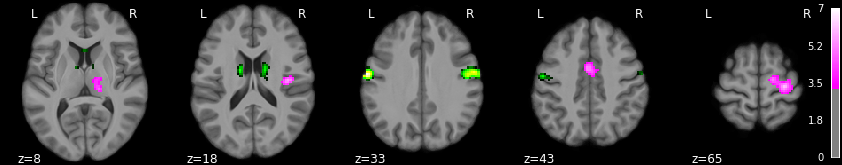

In [7]:
# showing overlay image (pink - low pain, green - high pain)
Image(filename='./figs/jf_hl_overlay_z.png')

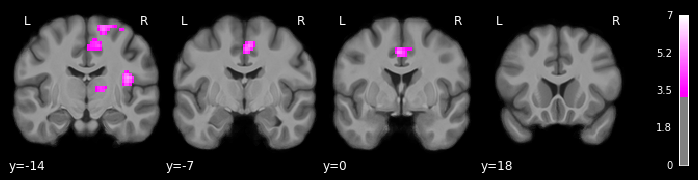

In [8]:
# plot x
peak_x = [-14, -7, 0, 18]
display2 = plotting.plot_stat_map(clean_map, threshold=threshold, vmax=7,
              display_mode='y', cut_coords=(peak_x), draw_cross=False, bg_img=bg,
                                 cmap=plotting.cm.black_pink)

In [9]:
display2.add_overlay(hi_map, threshold=threshold, cmap=plotting.cm.black_green)

In [10]:
display2.savefig('./figs/jf_hl_overlay_y.png')

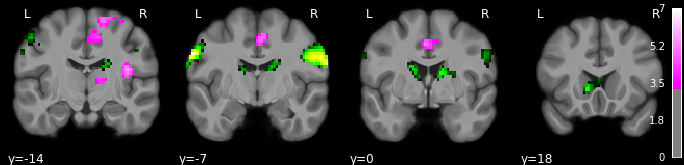

In [11]:
# showing overlay image (pink - low pain, green - high pain)
Image(filename='./figs/jf_hl_overlay_y.png')

correlation between generated and rated frequency in all subjects

In [12]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
def plot_bins(df,sj_idx=None,cut_num=10,model=None,
              obs='obs_p1g2',gen='gen_p1g2',
             obs_label='Generated probability p(L|H)', gen_label='Rated probability p(L|H)',
             diag_min=0.1, diag_max=0.9):
    """bin average then correlate"""
    fig, ax = plt.subplots(figsize=(4,4))
    all_sj = np.unique(df['subject'])
    if sj_idx is not None:
        sj_ls = sj_idx
    else:
        sj_ls = all_sj
    n_sj = len(sj_ls)
    r_sj = np.empty((n_sj,))
    model_sj = np.empty((n_sj, cut_num))
    rate_sj = np.empty((n_sj, cut_num))

#     for idx, sj in enumerate(np.unique(df['subject'])):
    for idx, sj in enumerate(sj_ls):
        df_sj = df[df['subject']==sj]
#         df_tmp = df_sj.dropna(subset=[obs])
        df_tmp = df_sj
        model_rank = df_tmp[gen].rank(method='max')
#         print(pd.qcut(model_rank, cut_num))
        model_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))[gen].mean().values
        rate_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))[obs].mean().values
        nas = np.logical_and(np.isnan(model_cut), np.isnan(rate_cut)) # get rid of nans
        # no demean
#         print(f'subject %d, pearsonr %.3f, pval %.3f' %(sj, pr, pv))
        pr, pv = scipy.stats.pearsonr(model_cut[~nas], rate_cut[~nas])
        sns.regplot(x=model_cut[~nas], y=rate_cut[~nas])      
        
        r_sj[idx] = pr
        model_sj[idx,:] = model_cut
        rate_sj[idx,:] = rate_cut


    ax.set_aspect('equal')#, adjustable='box')
    plt.plot([diag_min,diag_max],[diag_min,diag_max], 'k-')
    plt.xlabel(obs_label)
    plt.ylabel(gen_label)
    t0, p0 = scipy.stats.ttest_rel(r_sj,np.zeros((n_sj,)))
    plt.title(f'Pearson r={np.mean(r_sj):.3f} (t({len(r_sj)})={t0:.3f}, p={p0:.3e})')
    if model is not None:
        fig_name = f'bins_{model:s}.pdf'
        fig_path = os.path.join('figs',fig_name)
        plt.savefig(fig_path, bbox_inches='tight')

def demean(df):
    """demean"""
    df_dm = (df-np.mean(df))/np.std(df)
    return df_dm

In [14]:
df = pd.read_csv('../data/fmri_behavioural_new.csv')

In [15]:
dfna = df.dropna(subset=['obs_p1g2', 'obs_p2g1'], how='all')

In [16]:
dfna['gen_p1g1'] = 1 - dfna['gen_p2g1']
dfna['gen_p2g2'] = 1 - dfna['gen_p1g2']
dfna['gen_p1'] = (dfna['gen_p1g1'] + dfna['gen_p1g2'])/(dfna['gen_p1g1'] + dfna['gen_p1g2']+dfna['gen_p2g1'] + dfna['gen_p2g2'])
dfna['gen_p2'] = (dfna['gen_p2g1'] + dfna['gen_p2g2'])/(dfna['gen_p1g1'] + dfna['gen_p1g2']+dfna['gen_p2g1'] + dfna['gen_p2g2'])

<ipython-input-16-b84b32298ab8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna['gen_p1g1'] = 1 - dfna['gen_p2g1']
<ipython-input-16-b84b32298ab8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfna['gen_p2g2'] = 1 - dfna['gen_p1g2']
<ipython-input-16-b84b32298ab8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

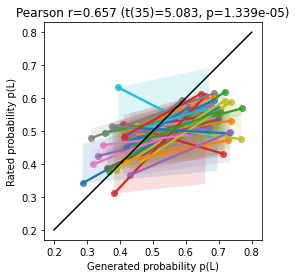

In [17]:
# all subjects
plot_bins(dfna, sj_idx=None,model=None, cut_num=2,
          obs='obs_p1',gen='gen_p1',
          obs_label='Generated probability p(L)', gen_label='Rated probability p(L)',
         diag_min=0.2, diag_max=0.8)

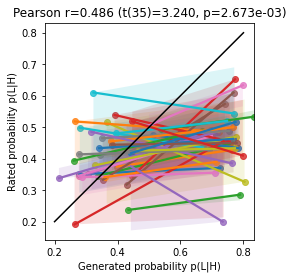

In [18]:
# all subjects
plot_bins(dfna, sj_idx=None,model=None, cut_num=2,
          obs='obs_p1g2',gen='gen_p1g2',
          obs_label='Generated probability p(L|H)', gen_label='Rated probability p(L|H)',
         diag_min=0.2, diag_max=0.8)

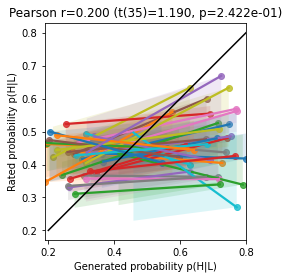

In [26]:
# all subjects
plot_bins(dfna, sj_idx=None,model=None, cut_num=2,
          obs='obs_p2g1',gen='gen_p2g1',
          obs_label='Generated probability p(H|L)', gen_label='Rated probability p(H|L)',
         diag_min=0.2, diag_max=0.8)

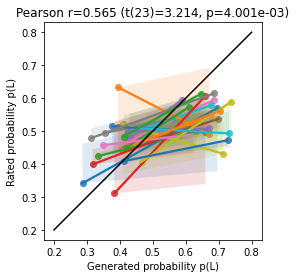

In [19]:
# freq group subjects
# sub-06/  sub-13/  sub-17/  sub-21/  sub-27/  sub-32/  sub-37/  sub-42/
# sub-07/  sub-14/  sub-19/  sub-24/  sub-30/  sub-33/  sub-39/  sub-43/
# sub-10/  sub-16/  sub-20/  sub-26/  sub-31/  sub-36/  sub-41/
freq_sj = [6,7,10,13,14,16,17,19,20,21,24,26,27,30,31,32,33,36,37,39,41,42,43]
plot_bins(dfna, sj_idx=freq_sj, model=None, cut_num=2,
          obs='obs_p1',gen='gen_p1',
          obs_label='Generated probability p(L)', gen_label='Rated probability p(L)',
         diag_min=0.2, diag_max=0.8)

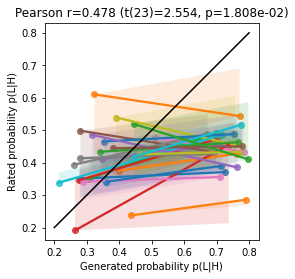

In [20]:
# freq group subjects
# sub-06/  sub-13/  sub-17/  sub-21/  sub-27/  sub-32/  sub-37/  sub-42/
# sub-07/  sub-14/  sub-19/  sub-24/  sub-30/  sub-33/  sub-39/  sub-43/
# sub-10/  sub-16/  sub-20/  sub-26/  sub-31/  sub-36/  sub-41/
freq_sj = [6,7,10,13,14,16,17,19,20,21,24,26,27,30,31,32,33,36,37,39,41,42,43]
plot_bins(dfna, sj_idx=freq_sj, model=None, cut_num=2,
          obs='obs_p1g2',gen='gen_p1g2',
          obs_label='Generated probability p(L|H)', gen_label='Rated probability p(L|H)',
         diag_min=0.2, diag_max=0.8)

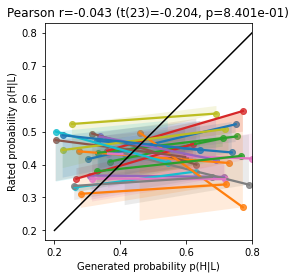

In [21]:
# freq group subjects
# sub-06/  sub-13/  sub-17/  sub-21/  sub-27/  sub-32/  sub-37/  sub-42/
# sub-07/  sub-14/  sub-19/  sub-24/  sub-30/  sub-33/  sub-39/  sub-43/
# sub-10/  sub-16/  sub-20/  sub-26/  sub-31/  sub-36/  sub-41/
freq_sj = [6,7,10,13,14,16,17,19,20,21,24,26,27,30,31,32,33,36,37,39,41,42,43]
plot_bins(dfna, sj_idx=freq_sj, model=None, cut_num=2,
          obs='obs_p2g1',gen='gen_p2g1',
          obs_label='Generated probability p(H|L)', gen_label='Rated probability p(H|L)',
         diag_min=0.2, diag_max=0.8)

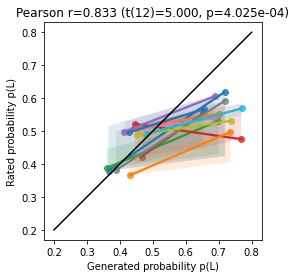

In [22]:
# trans group subjects
# sub-08/  sub-11/  sub-18/  sub-23/  sub-28/  sub-38/
# sub-09/  sub-15/  sub-22/  sub-25/  sub-29/  sub-44/
trans_sj = [8,9,11,15,18,22,23,25,28,29,38,44]
plot_bins(dfna, sj_idx=trans_sj, model=None, cut_num=2,
          obs='obs_p1',gen='gen_p1',
          obs_label='Generated probability p(L)', gen_label='Rated probability p(L)',
         diag_min=0.2, diag_max=0.8)

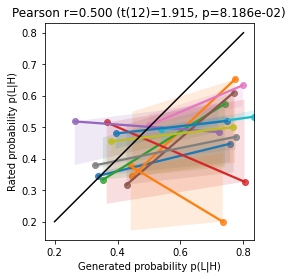

In [23]:
# trans group subjects
# sub-08/  sub-11/  sub-18/  sub-23/  sub-28/  sub-38/
# sub-09/  sub-15/  sub-22/  sub-25/  sub-29/  sub-44/
trans_sj = [8,9,11,15,18,22,23,25,28,29,38,44]
plot_bins(dfna, sj_idx=trans_sj, model=None, cut_num=2,
          obs='obs_p1g2',gen='gen_p1g2',
          obs_label='Generated probability p(L|H)', gen_label='Rated probability p(L|H)',
         diag_min=0.2, diag_max=0.8)

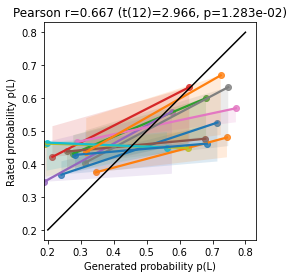

In [24]:
# trans group subjects
# sub-08/  sub-11/  sub-18/  sub-23/  sub-28/  sub-38/
# sub-09/  sub-15/  sub-22/  sub-25/  sub-29/  sub-44/
trans_sj = [8,9,11,15,18,22,23,25,28,29,38,44]
plot_bins(dfna, sj_idx=trans_sj,model=None, cut_num=2,
          obs='obs_p2g1',gen='gen_p2g1',
          obs_label='Generated probability p(L)', gen_label='Rated probability p(L)',
         diag_min=0.2, diag_max=0.8)